In [1]:
from cosmofast.planck2018._simall import _simall_f, _simall_j, _simall_fj
from cosmofast.planck2018._plik_lite_diag import _plik_lite_f, _plik_lite_j, _plik_lite_fj, _get_binned_cls
from cosmofast.planck2018._commander import _commander_f, _commander_j, _commander_fj
import dill
dill.settings['recurse'] = True

# Load the quadratic model for Planck 2018 Omega_K lilelihood
# Note that we do linear extrapolation outside the sample range
with open('data/den2.p', 'rb') as f:
    den2 = dill.load(f)

In [ ]:
'''
The prior range used by Planck is:
[(0.005, 0.1),
 (0.001, 0.99),
 (0.5, 10),
 (0.01, 0.8),
 (-0.3, 0.3),
 (1.61, 3.91),
 (0.8, 1.2),
 (0.9, 1.1)]
For the eight parameters:
omegabh2, omegach2, theta, tau, omegak, logA, ns, calPlanck
 
You may want to use the following methods of den2:
den2.logp(xx, surrogate=False, original=True)
den2.grad(xx, surrogate=False, original=True)
den2.logp_and_grad(xx, surrogate=False, original=True)
den2(xx, surrogate=False, original=True) -> same as den2.logp

Please do not modify the "surrogate" argument.
If "original" is True, the input should be the original parameters.
If "original" is False, then the input should be rescaled, 
so that the input range is (0, 1) for all the parameters.
Note that we only do a linear transform here,
instead of those non-linear constraint remove transforms.

You can use the following functions to transform the variables:
den2.from_original(xx)
den2.to_original(xx)
'''

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np

# These are the official Planck chains
x_mcmc = np.concatenate((
    np.loadtxt('data/base_omegak_plikHM_TT_lowl_lowE_1.txt')[:,2:10],
    np.loadtxt('data/base_omegak_plikHM_TT_lowl_lowE_2.txt')[:,2:10],
    np.loadtxt('data/base_omegak_plikHM_TT_lowl_lowE_3.txt')[:,2:10],
    np.loadtxt('data/base_omegak_plikHM_TT_lowl_lowE_4.txt')[:,2:10]))
p_mcmc = np.concatenate((
    np.loadtxt('data/base_omegak_plikHM_TT_lowl_lowE_1.txt')[:,0],
    np.loadtxt('data/base_omegak_plikHM_TT_lowl_lowE_2.txt')[:,0],
    np.loadtxt('data/base_omegak_plikHM_TT_lowl_lowE_3.txt')[:,0],
    np.loadtxt('data/base_omegak_plikHM_TT_lowl_lowE_4.txt')[:,0]))

In [3]:
from bayesfast.samplers.pymc3.nuts import NUTS
import bayesfast.utils.warnings as bfwarnings
import warnings

# Below is the temporary solution for printing the sampling progress
# We plan to rewrite it with e.g. tqdm in the future
warnings.showwarning = bfwarnings.showwarning_chain()
warnings.formatwarning = bfwarnings.formatwarning_chain()

In [4]:
nuts = NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: den2.logp_and_grad(xx, False, False)),
            x_0=den2.from_original(x_mcmc[0]), 
            random_state=np.random.RandomState(0), 
            metric=None, step_size=1., target_accept=0.9)
tt = nuts.run(2500, 500)

CHAIN #0: sampling proceeding [ 250 / 2500 ], last 250 samples used 18.25 seconds. (warmup)
CHAIN #0: sampling proceeding [ 500 / 2500 ], last 250 samples used 6.73 seconds. (warmup)
CHAIN #0: sampling proceeding [ 750 / 2500 ], last 250 samples used 6.23 seconds.
CHAIN #0: sampling proceeding [ 1000 / 2500 ], last 250 samples used 6.67 seconds.
CHAIN #0: sampling proceeding [ 1250 / 2500 ], last 250 samples used 6.34 seconds.
CHAIN #0: sampling proceeding [ 1500 / 2500 ], last 250 samples used 5.77 seconds.
CHAIN #0: sampling proceeding [ 1750 / 2500 ], last 250 samples used 6.47 seconds.
CHAIN #0: sampling proceeding [ 2000 / 2500 ], last 250 samples used 9.19 seconds.
CHAIN #0: sampling proceeding [ 2250 / 2500 ], last 250 samples used 10.21 seconds.
CHAIN #0: sampling finished   [ 2500 / 2500 ], obtained 2500 samples in 85.34 seconds.


In [5]:
x_bf = den2.to_original(np.array(tt.samples[501:]))

Removed no burn in
Removed no burn in


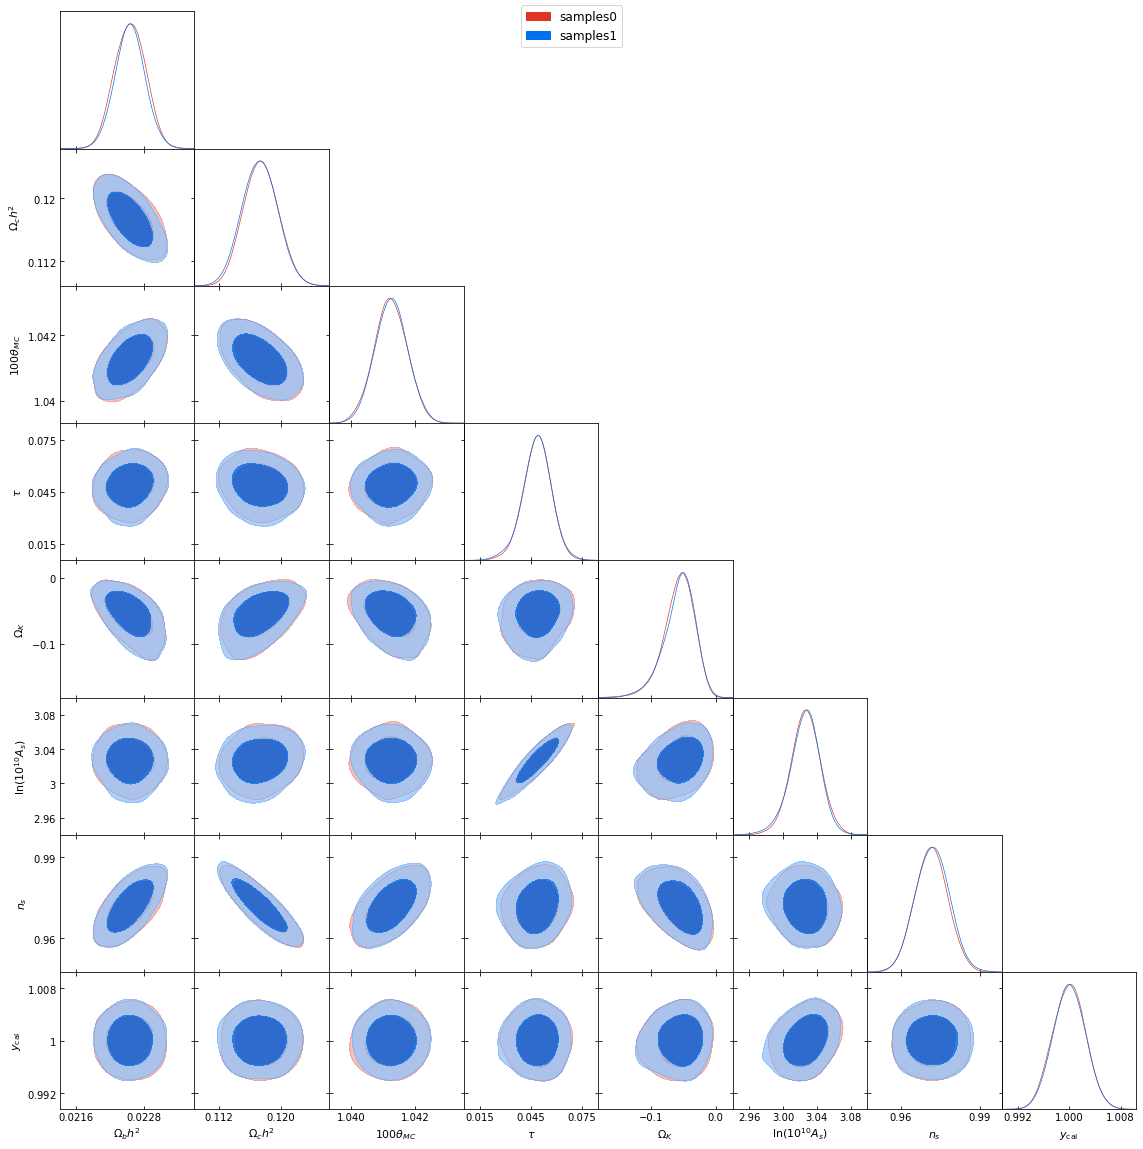

In [8]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(8)]
labels =  ['\\Omega_b h^2', '\\Omega_c h^2', '100\\theta_{MC}', '\\tau', 
           '\Omega_K', '{\\rm{ln}}(10^{10} A_s)', 'n_s', 'y_{\\rm cal}']
s_bf = MCSamples(samples=x_bf, names=names, labels=labels)
s_mcmc = MCSamples(samples=x_mcmc, weights=p_mcmc, names=names, labels=labels)
g = plots.getSubplotPlotter()
g.triangle_plot([s_bf, s_mcmc], filled=True, contour_args={'alpha':0.8})
plt.show()